In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import librosa
import librosa.display
import IPython.display as ipd
import tensorflow as tf
import h5py
from tqdm import tqdm
pwd = os.getcwd()
# load ravdess.npy , savee.npy and tess.npy
ravdess_data = np.load(pwd+'/data/npy_files/ravdess.npy')
savee_data = np.load(pwd+'/data/npy_files/savee.npy')
tess_data = np.load(pwd+'/data/npy_files/tess.npy')
crema_data = np.load(pwd+'/data/npy_files/crema.npy')

all_data = np.vstack((ravdess_data, savee_data, tess_data, crema_data))
df = pd.DataFrame(all_data, columns=[
                  'label', 'gender', 'pathname', 'filename'])

label_dict = { 'n': 0, 'c': 1, 'h': 2, 'sa': 3,
               'a': 4, 'f': 5, 'd': 6, 'su': 7 }
df['label'] = df['label'].map(label_dict)


def plot_spec(y, sr, hop_size, y_axis):
    plt.figure(figsize=(10, 7))
    librosa.display.specshow(
        y, sr=sr, hop_length=hop_size, x_axis='time', y_axis=y_axis)
    plt.colorbar(format='%+2.0f dB')
    plt.show()


frame_size = 4096  # in samples
hop_size = 512  # in samples
temporal_chunk_size = 42  # number of temporal bins per sample
mel_bands = 128  # number of mel bands
silence_threshold = 40  # in  relative to peak dB
in_dB = True  # convert to dB
mfcc_coefficients = 12  # number of MFCC coefficients

# total temporal bins is total_samples/hop_size
data_cols = ['stft_data', 'mel_data', 'mfcc_data']

f = h5py.File('dataset.h5', 'a')


def add_to_dataset(temporal_chunks):
    n_chunks = len(temporal_chunks)
    new_stft_data = np.array([temporal_chunks[i][0] for i in range(n_chunks)])
    new_mel_data = np.array([temporal_chunks[i][1] for i in range(n_chunks)])
    new_mfcc_data = np.array([temporal_chunks[i][2] for i in range(n_chunks)])
    new_gender_data = np.array([temporal_chunks[i][3]
                               for i in range(n_chunks)]).reshape(n_chunks, 1).astype('|S6')
    new_label_data = np.array([temporal_chunks[i][4]
                              for i in range(n_chunks)]).reshape(n_chunks, 1)
    # plot_spec(new_mel_data[0], sr, hop_size, 'mel')
    # plot_spec(new_mel_data[1], sr, hop_size, 'mel')
    # return
    if len(f.keys()) == 0:
        # create separate datasets for each col
        f.create_dataset('stft', data=new_stft_data,
                         compression="gzip", chunks=True, maxshape=(None, new_stft_data.shape[1], temporal_chunk_size))
        f.create_dataset('mel_spec', data=new_mel_data, compression="gzip",
                         chunks=True, maxshape=(None, mel_bands, temporal_chunk_size))
        f.create_dataset('mfcc', data=new_mfcc_data,
                         compression="gzip", chunks=True, maxshape=(None, mfcc_coefficients, temporal_chunk_size))
        f.create_dataset('gender', data=new_gender_data,
                         compression="gzip", chunks=True, maxshape=(None, 1))
        f.create_dataset('label', data=new_label_data,
                         compression="gzip", chunks=True, maxshape=(None, 1))

    f['stft'].resize((f['stft'].shape[0] + new_stft_data.shape[0]), axis=0)
    f['stft'][-new_stft_data.shape[0]:] = new_stft_data

    f['mel_spec'].resize(
        (f['mel_spec'].shape[0] + new_mel_data.shape[0]), axis=0)
    f['mel_spec'][-new_mel_data.shape[0]:] = new_mel_data

    f['mfcc'].resize((f['mfcc'].shape[0] + new_mfcc_data.shape[0]), axis=0)
    f['mfcc'][-new_mfcc_data.shape[0]:] = new_mfcc_data

    f['gender'].resize(
        (f['gender'].shape[0] + new_gender_data.shape[0]), axis=0)
    f['gender'][-new_gender_data.shape[0]:] = new_gender_data

    f['label'].resize((f['label'].shape[0] + new_label_data.shape[0]), axis=0)
    f['label'][-new_label_data.shape[0]:] = new_label_data


  0%|          | 0/12162 [00:00<?, ?it/s]

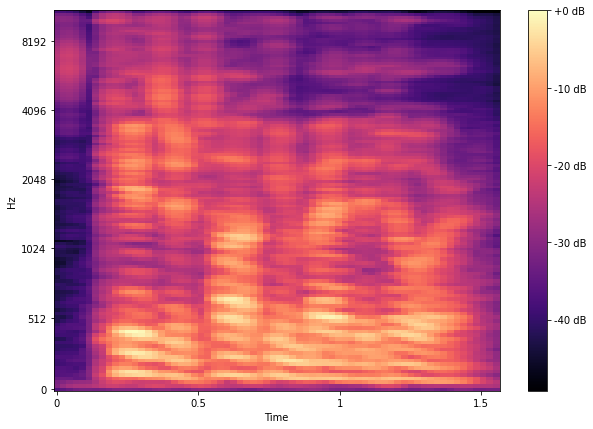

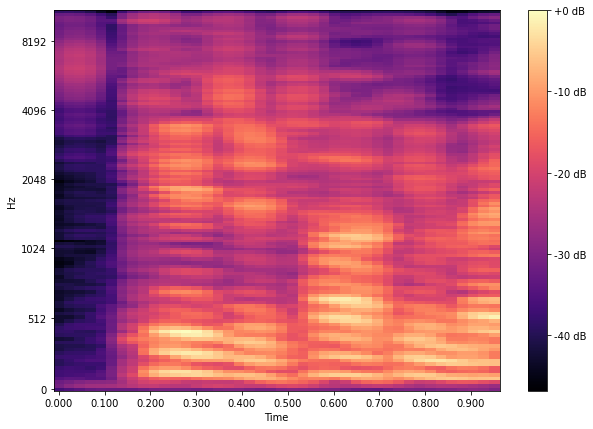

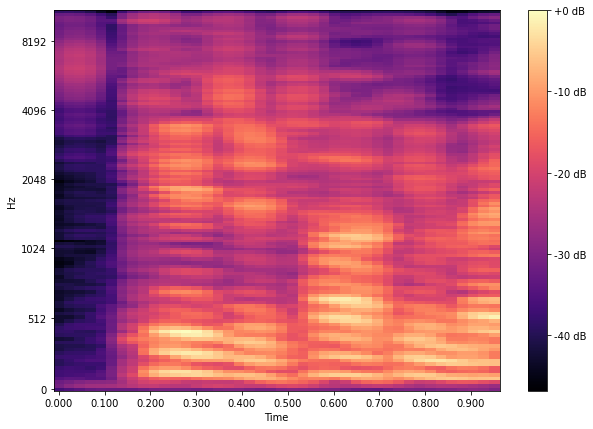

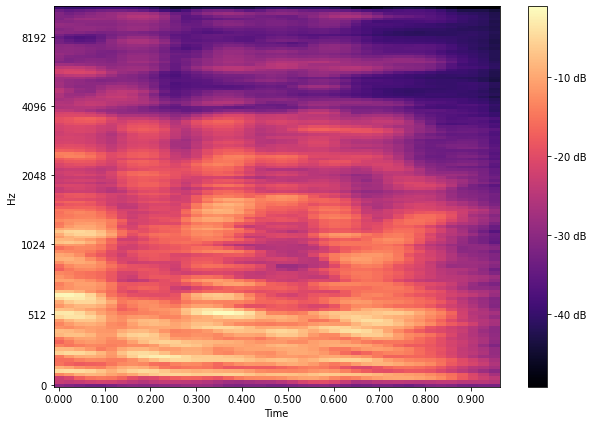

  0%|          | 1/12162 [01:31<309:35:06, 91.65s/it]


KeyboardInterrupt: 

In [4]:
for sample_index in tqdm(range(df.shape[0])):
    temporal_chunks = []

    pathname = df['pathname'][sample_index]
    filename = df['filename'][sample_index]

    wav, sr = librosa.load(pwd + pathname + filename)
    trimmed_wav, _ = librosa.effects.trim(wav, top_db=silence_threshold)

    if sr != 22050:
        raise ValueError("Sample rate is not 22050Hz")

    # extract audio features for the audio file
    S_audio = librosa.stft(trimmed_wav, n_fft=frame_size, hop_length=hop_size)
    y_audio = np.abs(S_audio)

    mel_spec = librosa.feature.melspectrogram(
        S=y_audio, sr=sr, n_fft=frame_size, hop_length=hop_size, n_mels=mel_bands)

    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(
        mel_spec), sr=sr, n_mfcc=mfcc_coefficients)

    if in_dB:
        y_audio = librosa.power_to_db(y_audio, ref=np.max)
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # split y into chunks of size temporal_chunk_size.
    _y = (y_audio).T
    _mel_spec = (mel_spec).T
    _mfccs = (mfccs).T

    split_indices = np.unique([(i, len(_y) - temporal_chunk_size)[int(
        i + temporal_chunk_size >= len(_y))]for i in range(0, len(_y), temporal_chunk_size)])

    # to include mel-spec add `_mel_spec[i:i+temporal_chunk_size].T` in the list
    [temporal_chunks.append([
        np.array(_y[i:i+temporal_chunk_size].T, dtype=np.float32),
        np.array(_mel_spec[i:i+temporal_chunk_size].T, dtype=np.float32),
        np.array(_mfccs[i:i+temporal_chunk_size].T, dtype=np.float32),
        df['gender'][sample_index],
        df['label'][sample_index]])
     for i in split_indices]

    # chunk_df = pd.DataFrame(data=temporal_chunks, columns=['stft_data', 'mel_data', 'mfcc_data', 'gender', 'label'])
    # plot_spec(y=mel_spec,sr=sr, hop_size=hop_size,y_axis='mel')
    # plot_spec(y=np.array(_mel_spec[0:0+temporal_chunk_size].T, dtype=np.float32),sr=sr, hop_size=hop_size,y_axis='mel')
    add_to_dataset(temporal_chunks)

In [ ]:

f.attrs['sample_rate'] = sr
f.attrs['window_size'] = frame_size
f.attrs['hop_size'] = hop_size
f.close()